# CS418 - MoneyMapping In Chicago: A dive into Grants Programs

By Sadika Almasri, Saja Bushara, Joshua Adereti, Freya Modi and Alisha Zaidi

This project examines how loans and grants in Chicago are distributed across neighborhoods, focusing on whether that distribution is equitable. Using datasets from SBIF, NOF, and other city funding programs alongside demographic data, we aim to answer our guiding questions: 

Are loans/grants in Chicago distributed equitably across neighborhoods? and How do socioeconomic/demographic factors relate to that distribution? 

Because Chicago’s neighborhoods differ sharply by race, income, and investment history, our data helps reveal whether funding supports communities proportionately or if certain areas receive more benefits than others.

Since the proposal, our overall scope hasn’t changed, but we refined our dataset choices. We removed older datasets because newer 2023-2025 data includes the same indicators and is more relevant. We added demographic and ownership share datasets so we could directly compare funding patterns with neighborhood characteristics. 

For data preparation, all datasets were loaded from CSVs and cleaned to make them consistent. This included standardizing column names, converting currency strings into numeric values, and aligning community area identifiers across files. We created a **grant coverage metric (incentive amount ÷ total project cost) to measure what fraction of each project was funded by SBIF or NOF**. After that, we grouped the data by community area to calculate total funding, project counts, and average percentage coverage, and then merged these results with demographic indicators like income and racial composition.

During exploratory data analysis, we reviewed dataset sizes, checked missing values, and summarized which neighborhoods appear most often in each grant program. We identified early patterns, like SBIF covering more neighborhoods than NOF and certain areas receiving higher total dollars and higher grant coverage percentages. We also ran simple correlations comparing grant coverage with demographic variables such as non-white household share and income level. These initial checks help us understand where disparities may exist and guide the direction of the deeper analysis.

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#this is just a checker to make sure the csv's r being loaded, disregard
def read_csv_any(p):
    try:
        return pd.read_csv(p, low_memory=False)
    except UnicodeDecodeError:
        return pd.read_csv(p, encoding="latin-1", low_memory=False)

paths = { 
    "cmi_loans": "Datasets/CMI_Microloans.csv",
    "cmi_demo": "Datasets/CMI_Microloans_By_Ethnicity_Gender.csv",
    "nof": "Datasets/NOF_Small_Projects_2025.csv",
    "sbif": "Datasets/SBIF_Applicants_Small_Business_Projects_2025.csv",
    "socio_old": "Datasets/Socioecon_Community_2008_2012.csv",
    "socio_new": "Datasets/Socioeconomic_Neighborhoods_2025.csv.csv",
    "socio_by_ca": "Datasets/chi_data_tract.csv",#ok this is just an update social_old, same df structure
}

dfs = {k: read_csv_any(p) for k,p in paths.items()}

# for name, df in dfs.items():
#     print(f"\n{name}: {df.shape[0]:,} rows and {df.shape[1]} cols")
#     print(df.columns.tolist()[:12])
#     print(df.head(3)) 


# Part 1 - Grant Coverage Metrics & Findings
To measure how much support each project actually receives, we created a new column called GRANT_RATIO, calculated in this way:

GRANT_RATIO = INCENTIVE AMOUNT ÷ TOTAL PROJECT COST

This tells us what percentage of a project was covered by the grant. Before calculating that, we cleaned the columns by removing symbols and converting everything into numbers. We also handled cases where the total project cost was zero so the ratio wouldn’t break. After that, we turned the ratio into GRANT_Percent to make it easier to read.

In [218]:
#these are grant programs:  sbif and nof grants , this is to see the grant/community 
#obervations: more sbif usage, ill look more into other columns to see why this is the case but its more sbif are long term, nof are pre project


for prog in ["sbif", "nof"]:
    dfs[prog].columns = dfs[prog].columns.str.strip()

#cleaning all the "$some number" to be nums. curr strings
def to_numeric_clean(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace(r"[^0-9.\-]", "", regex=True),
        errors="coerce"
    )

#grant ratios = INCENTIVE AMOUNT ÷ TOTAL PROJECT COST, this tells us what share of each project’s total request was covered by the EACH grant
for prog in ["sbif", "nof"]:
    df = dfs[prog]
    needed = ["INCENTIVE AMOUNT", "TOTAL PROJECT COST", "COMMUNITY AREA"]
    if "INCENTIVE AMOUNT" in df.columns:
        df["INCENTIVE AMOUNT"] = to_numeric_clean(df["INCENTIVE AMOUNT"])
    if "TOTAL PROJECT COST" in df.columns:
        df["TOTAL PROJECT COST"] = to_numeric_clean(df["TOTAL PROJECT COST"])

    #some projects dont actually have a cost so its $0.... if thats the case we dont want to devide lol
    if {"INCENTIVE AMOUNT", "TOTAL PROJECT COST"}.issubset(df.columns):
        denom = df["TOTAL PROJECT COST"].replace(0, np.nan)
        df["GRANT_RATIO"] = df["INCENTIVE AMOUNT"] / denom
    else:
        df["GRANT_RATIO"] = np.nan
    
    df["GRANT_Percent"] = (df["GRANT_RATIO"] * 100).round(1) #just turning the ratios into % for easier looks

print("SBIF GRANT_Percent summary (%):\n", dfs["sbif"]["GRANT_Percent"].dropna().describe())
print("NOF GRANT_Percent summary (%):\n", dfs["nof"]["GRANT_Percent"].dropna().describe())

print(dfs["sbif"]["GRANT_Percent"].dropna().map(lambda x: f"{x:.1f}%").head())


SBIF GRANT_Percent summary (%):
 count    2150.000000
mean       60.089581
std        18.367201
min         3.300000
25%        50.000000
50%        57.150000
75%        75.000000
max       100.000000
Name: GRANT_Percent, dtype: float64
NOF GRANT_Percent summary (%):
 count    119.000000
mean      54.594118
std       19.543950
min        1.700000
25%       47.850000
50%       52.500000
75%       69.400000
max      100.000000
Name: GRANT_Percent, dtype: float64
0    51.1%
1    49.3%
2    35.2%
3    75.0%
4    75.0%
Name: GRANT_Percent, dtype: object


# SBIF Grant - What the Numbers Mean:

count = 2,150 projects with valid values (others had missing cost or incentive data)

mean ≈ 0.601 -> on average, ~60% of each project’s cost is covered by SBIF

median ≈ 0.572 -> about half of projects have ≤ ~57% coverage!

IQR (25%–75%) = 0.50–0.75 -> the middle half of projects get 50–75% of costs covered

max = 1.0 -> some projects are fully covered (grant = total cost)

min ≈ 0.033 -> tiny coverage outliers (~3% subsidized)

What does this mean?

SBIF is clearly the more generous and widely used program. The average coverage (~60%) shows strong city participation in funding local business improvements. Many projects receive over half their total costs funded, suggesting SBIF is designed to make small upgrades financially realistic for business owners.


# NOF Grant - What the Numbers Mean:

count = 119 projects with valid data

mean ≈ 0.546 -> average coverage of ~55%

IQR (25%–75%) = 0.48–0.69 -> typical NOF projects cover ~48–69% of total costs

max = 1.0

min ≈ 0.017 → same range, much fewer high coverage projects

# Analysis

Looking at the summary stats above, SBIF clearly shows up more often in the data than NOF. SBIF also tends to have higher grant coverage percentages overall, while NOF’s percentages are lower and more spread out. We haven't made claims about why yet, but the numbers themselves show the two programs function differently in terms of how much of the project they’re actually covering.

These initial stats help set the baseline for understanding what normal coverage looks like in each program. When we start connecting grant coverage to neighborhood characteristics like income, demographics, or ownership patterns later, we’ll be able to tell whether a community is getting unusually high or low support compared to the typical SBIF or NOF project.

In [219]:
#community areas BY project count
print("SBIF:top 20 community areas by count:\n")
print(dfs["sbif"]["COMMUNITY AREA"].value_counts().head(20))


print("NOF:top 20 community areas by count:\n")
print(dfs["nof"]["COMMUNITY AREA"].value_counts().head(20))

#this is just for missing stuff
# print("SBIF missing (top 10):\n")
# print(dfs["sbif"].isna().sum().sort_values(ascending=False).head(10))

# print("NOF missing(top 10):\n")
# print(dfs["nof"].isna().sum().sort_values(ascending=False).head(10))

#this is just checking if the people who applied for sbif maybe also did nof from a parituclar community : SBIF covers the majority of chicago neighborhoods
sbif_areas = set(dfs["sbif"]["COMMUNITY AREA"].dropna().astype(str).str.strip().unique()) if "COMMUNITY AREA" in dfs["sbif"].columns else set()
nof_areas  = set(dfs["nof"]["COMMUNITY AREA"].dropna().astype(str).str.strip().unique())  if "COMMUNITY AREA" in dfs["nof"].columns  else set()

#idk this might be useful, leave this here
print("\nAreas in both SBIF & NOF:", len(sbif_areas & nof_areas))
print("Areas only in SBIF:", len(sbif_areas - nof_areas))
print("Areas only in NOF:",  len(nof_areas - sbif_areas))


# here, we are removing any nulls for community area and %, grouping by commuity area so they show up once and calculating median and mean of those grant %'s
sbif_by_ca = (
    dfs["sbif"].dropna(subset=["COMMUNITY AREA","GRANT_Percent"]).groupby("COMMUNITY AREA")["GRANT_Percent"]
      .agg(count="count", mean="mean", median="median")
      .sort_values("mean", ascending=False)
)

sbif_dollars = (
    dfs["sbif"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]).groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum()
      .sort_values(ascending=False)
)

nof_dollars = (
    dfs["nof"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]).groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum()
      .sort_values(ascending=False)
)
print("\nTotal SBIF dollars by neighborhood (top 20):")
print(sbif_dollars.head(20))

print("\nTotal NOF dollars by neighborhood (top 20):")
print(nof_dollars.head(20))

print("who gets the biggest % coverage by neighborhood")
print(sbif_by_ca.head(30))


SBIF:top 20 community areas by count:

COMMUNITY AREA
Near West Side     160
Portage Park       138
West Town          111
Lincoln Square      88
Logan Square        84
Austin              82
North Center        80
Edgewater           79
Humboldt Park       79
Uptown              77
Albany Park         77
Belmont Cragin      63
New City            58
North Park          56
West Ridge          51
North Lawndale      49
Mount Greenwood     49
Bridgeport          46
Hermosa             41
Jefferson Park      40
Name: count, dtype: int64
NOF:top 20 community areas by count:

COMMUNITY AREA
South Lawndale            15
Grand Boulevard            9
North Lawndale             8
Chicago Lawn               7
South Shore                6
Austin                     6
Calumet Heights            5
Auburn Gresham             5
Greater Grand Crossing     5
Avalon Park                5
Roseland                   5
South Chicago              5
Humboldt Park              4
New City                   4
E

Looking at how many projects each neighborhood has above, SBIF clearly shows the widest reach. Neighborhoods like Near West Side, Portage Park, West Town, and Lincoln Square have anywhere from around 80 to over 160 SBIF projects, showing that the program is used across a huge range of communities. NOF is way smaller in volume, with its highest counts in places like South Lawndale, Grand Boulevard, and North Lawndale, where project numbers range from just a couple to about fifteen. Right away, this tells us the two programs operate at very different scales and in different parts of the city.

The distribution of dollars reflects the same pattern. SBIF neighborhoods like Near West Side, Portage Park, and West Town receive several million dollars each, whereas NOF’s highest totals appear in South Lawndale, North Lawndale, and Auburn Gresham, but at a smaller overall scale. SBIF is essentially the “big money, big footprint” program, while NOF is smaller but more concentrated in historically under-invested areas. When we look at average grant coverage by neighborhood, areas like Gage Park, Washington Park, East Side, Woodlawn, and Beverly show very high percentage coverage, often in the 70–90 percent range. This becomes important later when we compare grant coverage to demographics because it hints that some communities may be receiving a higher share of support per project even if they have fewer projects overall.

In [220]:
socio = pd.read_csv("Datasets/chi_data.csv")

# come back to this later loan stuff later

# socio["loan_amount_per_hh"] = socio["total_loan_amount"] / socio["total_hh"]
# socio["loans_per_1k_hh"] = socio["total_loans"] / (socio["total_hh"] / 100)

# print(socio[["loan_amount_per_hh","non_white_hh_share","ami_shr"]].corr())

socio["community_area"] = socio["community_area"].str.strip().str.lower()
dfs["sbif"]["COMMUNITY AREA"] = dfs["sbif"]["COMMUNITY AREA"].astype(str).str.strip().str.lower()
dfs["nof"]["COMMUNITY AREA"]  = dfs["nof"]["COMMUNITY AREA"].astype(str).str.strip().str.lower()


#just avg of grant % coverage by community area
sbif = dfs["sbif"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()
nof  = dfs["nof"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()

#merging the community areas for sbif and nof-> primary key
merged = socio.merge(sbif, left_on="community_area", right_on="COMMUNITY AREA", how="left").merge(nof, left_on="community_area", right_on="COMMUNITY AREA", how="left")

# note i split these up bc the printing was a mess and it was hard to see, all of this is explained in the readme
print("\ndemographic shares:")
print(merged[["community_area","white_hh_share","black_hh_share","latino_hh_share","non_white_hh_share"]].head(20).to_string(index=False))

print("\nownership shares:")
print(merged[["community_area","white_own_shr","black_own_shr","latino_own_shr","non_white_own_shr"]].head(20).to_string(index=False))

print("\nincome & grant coverage relationship:")
print(merged[["community_area","ami_shr","income_level","low_inc","GRANT_Percent_x","GRANT_Percent_y"]].head(20).to_string(index=False))



demographic shares:
    community_area  white_hh_share  black_hh_share  latino_hh_share  non_white_hh_share
       albany park        0.418062        0.047689         0.364065            0.581938
    archer heights        0.281593        0.008170         0.649732            0.718407
     armour square        0.171386        0.091986         0.044605            0.828614
           ashburn        0.143886        0.517315         0.309608            0.856114
    auburn gresham        0.009184        0.959228         0.013805            0.990816
            austin        0.061827        0.811605         0.111939            0.938173
       avalon park        0.018486        0.956033         0.000000            0.981514
          avondale        0.460985        0.029023         0.446657            0.539015
    belmont cragin        0.210503        0.033998         0.726230            0.789497
           beverly        0.585149        0.346440         0.044899            0.414851
        bri

# Part 2: Linking Grant Coverage Metric with Demographics

Now, here is where we try to make use of the data from chi_data.csv, which is a dataset that combines neighborhood level data. We have split these into 3 different datasets, with the last dataset connecting Income and Grant Coverage metric.

# Dataset 1: Demographic Shares

These columns describe the racial and ethnic makeup of each neighborhood. 

This dataset shows a strong racial pattern across neighborhoods. Burnside stands out as almost entirely Black, with 95% Black households, and Austin also shows a heavily Black population at 81%. White-majority neighborhoods appear on the opposite end, such as Dunning with 73% white households. Latino neighborhoods like Brighton Park (10% white households) and Belmont Cragin (18% white households) still show overwhelmingly non white populations. Overall, these numbers reveal a clear racial geography where Black and Latino communities cluster in distinct, lower-income areas, while white residents concentrate in higher-income zones.

This is not super shocking as this just reflects the patterns of segregation and unequal economic opportunity in Chicago, which our group had talked about as apart of our initial hypothesis.

# Dataset 2: Ownership Shares

These columns describe who owns homes in each area.

This dataset shows who actually controls property in these same neighborhoods, and the alignment varies by community. Black neighborhoods have the strongest resident owner match: Burnside is 93% Black among owners and Austin has 72% Black homeowners, closely mirroring their household shares. But Latino neighborhoods reveal ownership gaps: Brighton Park, despite only 10% white households, has 16% white homeowners, and Archer Heights rises from 28% white households to 30% white owners. These mismatches suggest that in some neighborhoods (especially Latino ones ) the people living there are not always the ones benefiting from property based investments.

# Dataset 3: Income and Grant Coverage Metric

These columns connect neighborhood income levels with grant program outcomes.

This dataset shows income patterns follow race directly: East Garfield Park has an AMI of 0.30, Burnside 0.35, and Austin 0.40, while white majority Beverly sits far above the regional median at 1.20. When you look at grant coverage, SBIF consistently provides larger percentages in higher-income neighborhoods. For example, Beverly receives 73%, Ashburn 73%, and Avondale 63%, compared to lower income communities like Burnside (46%) and East Garfield Park (55%). NOF, however, behaves differently: Austin receives 62%, Brighton Park 64%, and Belmont Cragin 61%, while wealthier areas show no NOF activity at all. This dataset clearly shows SBIF reinforcing property wealth while NOF directs more support to under-resourced neighborhoods.

These indicators are important in helping us assess whether lower income or majority non white neighborhoods receive higher or lower levels of financial support from city grant programs. Which we found some interesting results from in the next section. 

In [221]:
#grant coverage and neighborhood characteristics relatiosbusp

#SBIF correlations (GRANT_Percent_x)
sbif_corr = merged[[
    "white_hh_share","black_hh_share","latino_hh_share",
    "non_white_hh_share","ami_shr","GRANT_Percent_x"
]].corr()["GRANT_Percent_x"].drop("GRANT_Percent_x")

print("\nSBIF correlations with neighborhood factors:")
print(sbif_corr.to_string())

# NOF correlations 
nof_corr = merged[[
    "white_hh_share","black_hh_share","latino_hh_share",
    "non_white_hh_share","ami_shr","GRANT_Percent_y"
]].corr()["GRANT_Percent_y"].drop("GRANT_Percent_y")

print("\nNOF correlations with neighborhood factors:")
print(nof_corr.to_string())



SBIF correlations with neighborhood factors:
white_hh_share        0.001029
black_hh_share        0.044600
latino_hh_share      -0.044506
non_white_hh_share   -0.001029
ami_shr               0.041459

NOF correlations with neighborhood factors:
white_hh_share       -0.093381
black_hh_share       -0.164185
latino_hh_share       0.236529
non_white_hh_share    0.093381
ami_shr              -0.002954


# Grants and Demographic/Income Relationship Findings

# What the SBIF numbers show

Now for the real findings...

The SBIF correlations show that grant coverage has no meaningful relationship to neighborhood race or income. The numbers are essentially zero across the board: white household share (+0.001), Black household share (+0.045), Latino household share (–0.045), non-white household share (–0.001), and even income (AMI, +0.041) all sit far below the threshold of a real association. These tiny values mean SBIF provides roughly the same percentage of project cost coverage regardless of whether a neighborhood is white, Black, latino, low-income, or higher-income. In other words, the SBIF formula is statistically neutral! It does not increase or decrease grant percentage based on demographic or income characteristics.

# What the NOF numbers show

The NOF correlations show slightly more direction, but still weak patterns... Coverage tends to be somewhat higher in Latino neighborhoods, reflected in the positive correlation with Latino household share (+0.237) and with non white household share (+0.093). Meanwhile, coverage is slightly lower in whiter (–0.093) or Black-majority (–0.164) neighborhoods. Income has no real relationship to NOF coverage either, shown by the near zero AMI correlation (–0.003). Overall, these values indicate that NOF leans gently toward supporting Latino or mixed-race areas, but the relationships are weak and do not represent a strong/systematic policy pattern.


# Summary of findings and next steps

The data shows that Chicago’s major grant programs are very consistent in how they cover project costs across different neighborhoods. Even in areas with dramatically different racial or income compositions, the share of project costs covered by grants stays within a similar range  between 50% and 70%. The correlation results confirm this: SBIF coverage has almost no relationship with race or income (so with correlations like white_hh_share +0.001, black_hh_share +0.045, latino_hh_share –0.045, and ami_shr +0.041), and NOF coverage also shows only very weak associations (such as latino_hh_share +0.237 and white_hh_share –0.093).

 This indicates that the grant formulas themselves are NOT favoring any specific racial group or income level in how much funding each approved project receives.

However, the bigger issue isn't the percentage covered, but it’s who actually gets to participate. Wealthier or more active neighborhoods show up far more often in the data as we showed by the counts of applications per neightborhood. They submit more applications and launch more qualifying projects. Neighborhoods on the South and West Sides, which experience the greatest economic hardship, appear less frequently not because grants are less generous there, but because fewer projects enter the pipeline in the first place. This points to barriers in participation, (so factors such as access, awareness, capacity, or resources) rather than unfair treatment in the grant itself. In short, Chicago’s grants are equitable in how much they fund, but not everyone has the same level of access to the process that unlocks those dollars.

The next steps for this portion is creating a visualization which reflects this particular finding.

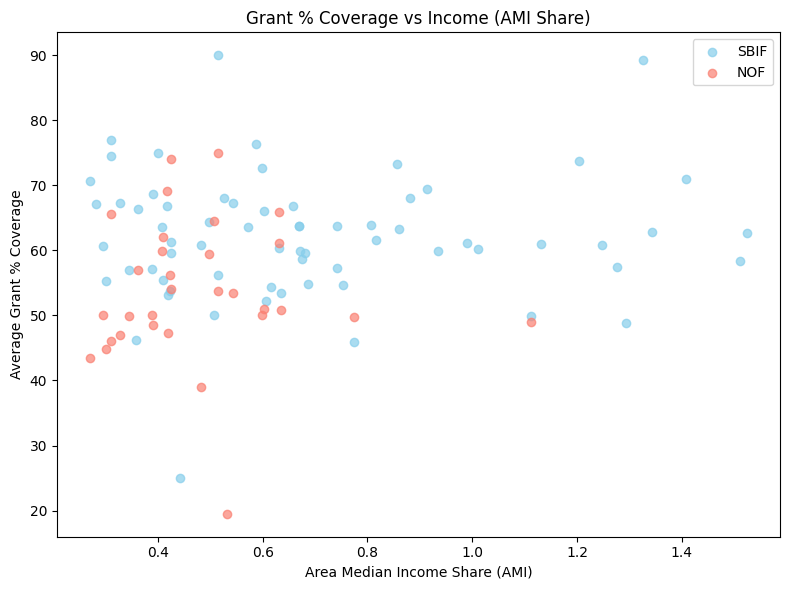

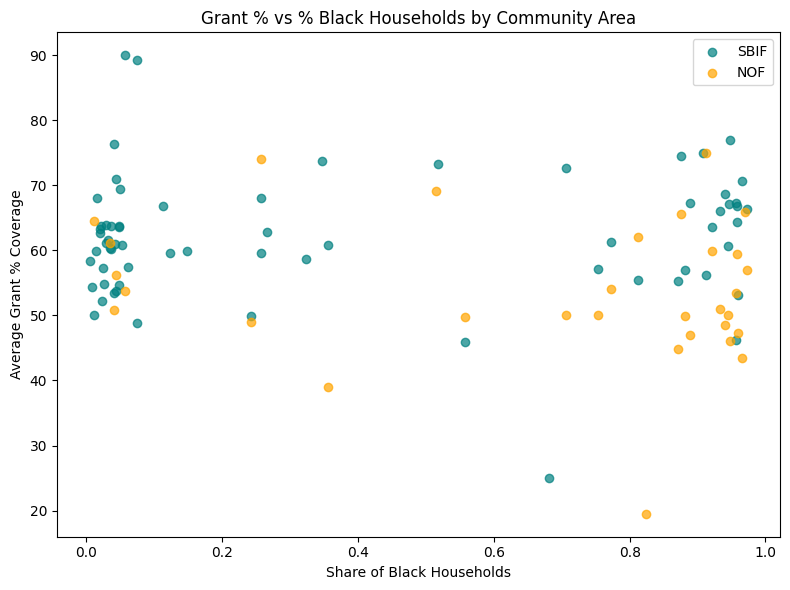

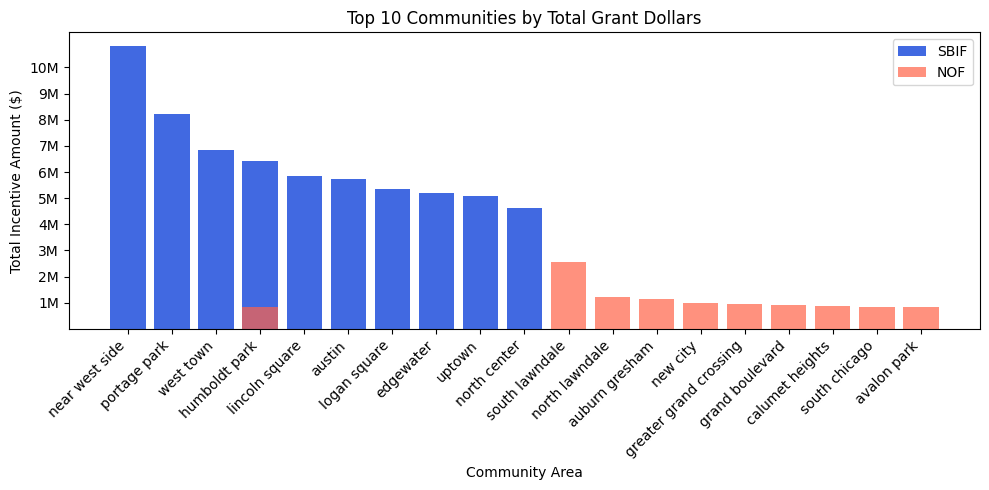

In [222]:
# By: Freya M

import matplotlib.pyplot as plt
socio = pd.read_csv("Datasets/chi_data.csv")
socio["community_area"] = socio["community_area"].str.strip().str.lower()

sbif = dfs["sbif"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()
nof  = dfs["nof"].groupby("COMMUNITY AREA")["GRANT_Percent"].mean().reset_index()

merged = socio.merge(sbif, left_on="community_area", right_on="COMMUNITY AREA", how="left") \
              .merge(nof, left_on="community_area", right_on="COMMUNITY AREA", how="left")

merged.rename(columns={"GRANT_Percent_x": "SBIF_Grant%", "GRANT_Percent_y": "NOF_Grant%"}, inplace=True)



plt.figure(figsize=(8,6))
plt.scatter(merged["ami_shr"], merged["SBIF_Grant%"], label="SBIF", alpha=0.7, color='skyblue')
plt.scatter(merged["ami_shr"], merged["NOF_Grant%"], label="NOF", alpha=0.7, color='salmon')
plt.title("Grant % Coverage vs Income (AMI Share)")
plt.xlabel("Area Median Income Share (AMI)")
plt.ylabel("Average Grant % Coverage")
plt.legend()
plt.tight_layout()
plt.show(block=True)

plt.figure(figsize=(8,6))
plt.scatter(merged["black_hh_share"], merged["SBIF_Grant%"], label="SBIF", color='teal', alpha=0.7)
plt.scatter(merged["black_hh_share"], merged["NOF_Grant%"], label="NOF", color='orange', alpha=0.7)
plt.title("Grant % vs % Black Households by Community Area")
plt.xlabel("Share of Black Households")
plt.ylabel("Average Grant % Coverage")
plt.legend()
plt.tight_layout()
plt.show(block=True)

sbif_dollars = dfs["sbif"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]) \
    .groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum().sort_values(ascending=False).head(10)
nof_dollars = dfs["nof"].dropna(subset=["COMMUNITY AREA","INCENTIVE AMOUNT"]) \
    .groupby("COMMUNITY AREA")["INCENTIVE AMOUNT"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(sbif_dollars.index, sbif_dollars.values, color='royalblue', label="SBIF")
plt.bar(nof_dollars.index, nof_dollars.values, color='tomato', alpha=0.7, label="NOF")

plt.title("Top 10 Communities by Total Grant Dollars")
plt.xlabel("Community Area")
plt.ylabel("Total Incentive Amount ($)")
plt.xticks(rotation=45, ha='right')
plt.legend()

ticks = [i * 1e6 for i in range(1, 11)]  
labels = [f"{i}M" for i in range(1, 11)]
plt.yticks(ticks, labels)

plt.tight_layout()
plt.show(block=True)



LOANS AND DEMOGRAPHIC/INCOME FINDINGS AND RELATIONSHIPS

By: Sadika A

LOANS: CHI_DATA_TRACT.CSV

This dataset contains information about 803 census tracts in Chicago. A census tract is just a small neighborhood-sized area used by the government for collecting data. For each tract, the dataset includes basic demographic information like the number of white, Black, Latino, Asian, and non-white households, as well as how many in each group are homeowners.
The dataset also includes a lot of financial and lending information. For example, it shows how many large, medium, and small business loans were given in each tract, and the total dollar amount of those loans.  Overall, it gives a picture of the racial makeup, homeownership, and business lending activity in each neighborhood across the city.




This data describes 496 small areas (tracts).

For each tract, you know how many households belong to different races, and some financial activity like loans and retail presence. Numbers vary a lot: some areas are very small with few people and loans, others are big with thousands of households and millions in loans.

You can see averages (mean), typical middle values (median), and how spread out the numbers are (standard deviation and min/max).

The stats shows:

On average, there are more White households than Black or Latino households, but some tracts have very few or no households of certain races, while others have thousands. 

ALso some loan amounts and retail loans vary widely; most areas have moderate activity, but a few tracts have very high loan volumes, which increases the average. 

Overall, the data shows that population and financial activity are unevenly distributed across tracts, with some areas much larger or more active than others.


In [223]:
from main import dfs 
df = dfs["socio_by_ca_tract"]
df.columns = df.columns.str.strip()
df = df.drop_duplicates()
df['income_level'] = df['income_level'].str.strip().str.lower()
df = df.dropna()
print(df.describe())

               tract     white_hh     black_hh    latino_hh     asian_hh  \
count     496.000000   496.000000   496.000000   496.000000   496.000000   
mean   343570.495968   813.612903   323.122984   293.991935   117.618952   
std    288845.736193   812.491322   505.272995   318.933101   203.217766   
min     10100.000000     0.000000     0.000000     0.000000     0.000000   
25%     81402.750000   194.500000    27.000000    60.000000    11.750000   
50%    241050.000000   664.000000    74.000000   179.500000    56.000000   
75%    643050.000000  1150.750000   401.750000   423.250000   132.500000   
max    843900.000000  6726.000000  3046.000000  1543.000000  2326.000000   

           oth_hh  non_white_hh  white_owners  black_owners  latino_owners  \
count  496.000000    496.000000    496.000000    496.000000     496.000000   
mean    32.745968    767.479839    433.727823    114.050403     133.715726   
std     39.304972    565.173784    451.296047    252.969586     182.274512   
min

Visualization #1 for chi_data_tract

This bar chart shows the average number of loans by racial group. 

From the visualization, we can see that:
The group labeled loans_white has the highest average number of loans, close to 50.
loans_latino and loans_black follow, but with considerably lower averages.
loans_asian and loans_oth have the lowest loan averages.

Hypothesis:
Do certain racial groups receive more loans on average than others? 

The visualization suggests that white households receive more loans on average, which could point to possible disparities in loan approval rates.


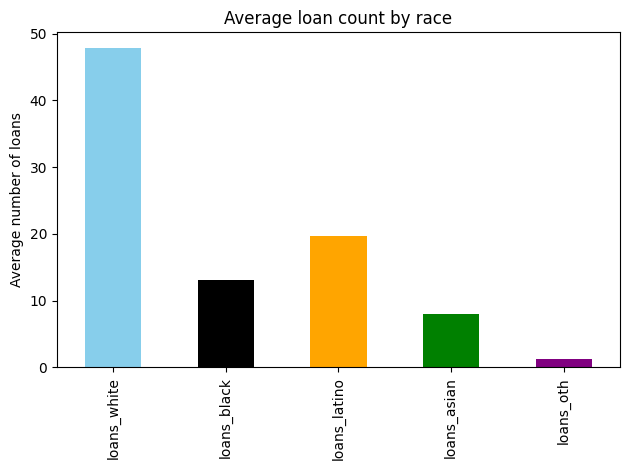

In [ ]:
from main import dfs 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = dfs["socio_by_ca_tract"]
df.columns = df.columns.str.strip()
df = df.drop_duplicates()
df['income_level'] = df['income_level'].str.strip().str.lower()

loan_cols = ["loans_white", "loans_black", "loans_latino", "loans_asian", "loans_oth"]

# bar chart - average number of loans by race
df[loan_cols].mean().plot(kind='bar', color=['skyblue','black','orange','green','purple'])
plt.ylabel("Average number of loans")
plt.title("Average loan count by race")
plt.tight_layout()
plt.show()


Visualization #2 for chi_data_tract

This visualization shows the top 10 and bottom 10 Chicago community areas ranked by average number of loans. 

The top neighborhoods display very high loan averages, suggesting that these areas have more borrowing activity overall, while the bottom neighborhoods show much lower averages. 

From the data alone, we cannot say exactly why this difference exists, but we can see that loan activity is not evenly distributed across the city. 

An interesting hypothesis based on this pattern is that neighborhoods with more economic or residential activity will naturally have more loans, while areas with less activity will have fewer.

This makes the visualization interesting because it raises questions about what might drive these differences, which can be explored with additional data.

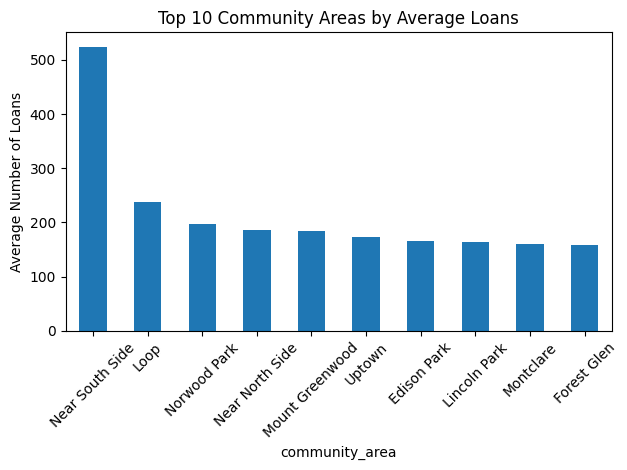

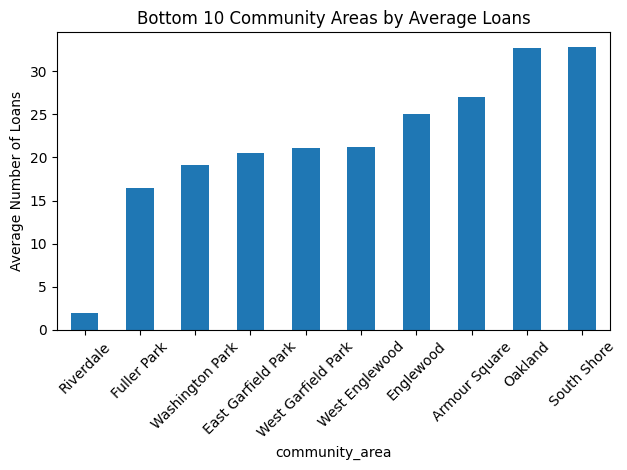

In [225]:
# Top 10 community areas by average number of loans
community_loans = df.groupby("community_area")["total_loans"].mean().sort_values(ascending=False).head(10)

community_loans.plot(kind='bar')
plt.ylabel("Average Number of Loans")
plt.title("Top 10 Community Areas by Average Loans")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

least_community_loans = df.groupby("community_area")["total_loans"].mean().sort_values(ascending=True).head(10)


least_community_loans.plot(kind='bar')
plt.ylabel("Average Number of Loans")
plt.title("Bottom 10 Community Areas by Average Loans")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Visualization #3 for chi_data_tract

This bar chart shows the total loan amount distributed across three income levels: 
low-to-moderate income (lmi), middle income (mi), and upper income (ui). 

We created this visualization to explore whether total loan distribution differs significantly by income level.

Hypothesis: higher-income groups receive a larger share of total loans.

From the visualization, we can see that:

Upper-income (ui) groups receive the highest total loan amount, exceeding $12,000M.
Low-to-moderate income (lmi) groups receive a moderate total, around $7,000M.
Middle-income (mi) groups receive the lowest total, around $4,000M.

This pattern suggests that total loan amounts tend to increase with income level. It may reflect differences in borrowing capacity, creditworthiness, or access to financial opportunities among income groups.


   total_loans  total_loan_amount income_level
0          100           21525000          lmi
1          142           28325000          lmi
2           43            8875000          lmi
3          152           31305000          lmi
4           71           18050000           mi
5           92           17725000          lmi
6           72           14440000          lmi
7            8            2190000          NaN
8          182           40315000           mi
9          107           24600000          lmi
count    8.030000e+02
mean     3.048463e+07
std      3.771364e+07
min      0.000000e+00
25%      7.530000e+06
50%      1.768500e+07
75%      4.029000e+07
max      4.626650e+08
Name: total_loan_amount, dtype: float64


/var/folders/qt/jjs3n41936s1gz0kjsdc7rj80000gn/T/ipykernel_17819/4008718024.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['${:,.0f}M'.format(x/1e6) for x in ax.get_yticks()])


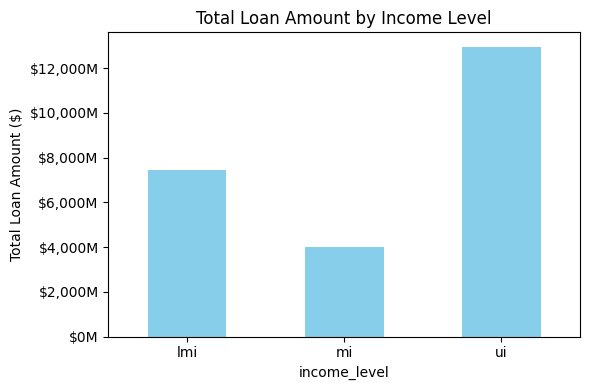

In [226]:


df['total_loan_amount'] = pd.to_numeric(df['total_loan_amount'], errors='coerce')
income_loan_amount = df.groupby("income_level")["total_loan_amount"].sum()
income_loan_amount.plot(kind='bar')

print(df[['total_loans', 'total_loan_amount', 'income_level']].head(10))
print(df['total_loan_amount'].describe())

ax = income_loan_amount.plot(kind='bar', color='skyblue', figsize=(6,4))
plt.ylabel("Total Loan Amount ($)")
plt.title("Total Loan Amount by Income Level")
plt.xticks(rotation=0)
ax.set_yticklabels(['${:,.0f}M'.format(x/1e6) for x in ax.get_yticks()])
plt.tight_layout()
plt.show()





BY: FREYA MODI

LOAN DATASET: chi_data.csv

This dataset provides information that helps evaluate whether loans and grants in Chicago are distributed equitably across neighborhoods. It includes key socioeconomic indicators such as median household income, poverty levels, and racial demographics, along with financial variables like the rate of business closures and the availability of banks or business support institutions. Together, these variables allow us to compare where economic resources such as loans in this case are more accessible and where they might be lacking. By examining patterns across neighborhoods, we can see how factors like race, income, and existing financial infrastructure relate to the distribution of funding, helping us identify which communities may be underserved or disproportionately supported.

The statistics for chi_data:

where it presents statistics of the distribution of loans and neighborhood racial composition across 77 neighborhoods. It would compare the share of loans each racial group receives to the population share of that group in each neighborhood. Positive alignment means a group receives loans roughly proportional to its population. If a group’s loan share is consistently lower than its population share, it may indicate under lending, and higher shares suggest over representation. This is basically the first step to see how loan distribution relates to neighborhood demographics.

Look at the output for the stats first

After looking into it the stats presents:

Approximately, white borrowers receive about 35% of loans, black and Latino borrowers around 27–28%, and Asian borrowers about 8%. Other or non-white borrowers receive smaller shares. Neighborhood demographic shares vary widely, reflecting areas with both homogeneous and diverse populations.

Basically these numbers suggest that loan allocation is uneven across racial groups and neighborhoods. The large standard deviations indicate that some neighborhoods strongly favor certain groups while others do not, which may highlight disparities in access.

So it shows that the data reveal that loan distribution does not perfectly match neighborhood racial composition. Some groups are consistently over or underrepresented relative to their share of the population.



In [227]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dfs = dfs["socio_by_data"] 
dfs.head()

loan_shares = ['loans_white_shr', 'loans_black_shr', 'loans_latino_shr',
               'loans_asian_shr', 'loans_oth_shr', 'loans_non_white_shr']

dem_shares = ['white_hh_share', 'black_hh_share', 'latino_hh_share',
              'asian_hh_share', 'oth_hh_share', 'non_white_hh_share']

income_cols = ['income_level', 'low_inc', 'loans_lmi_shr', 'loans_mi_shr', 'loans_ui_shr', 'ami_shr']

print("Descriptive statistics for loan shares:\n")
print(dfs[loan_shares].describe())

print("\nDescriptive statistics for demographic shares:\n")
print(dfs[dem_shares].describe())


Descriptive statistics for loan shares:

       loans_white_shr  loans_black_shr  loans_latino_shr  loans_asian_shr  \
count        77.000000        77.000000         77.000000        77.000000   
mean         34.985258        27.438385         28.433580         7.928260   
std          28.621557        32.522231         27.236349        12.812639   
min           0.000000         0.602410          0.000000         0.000000   
25%           7.017544         2.297461          7.561930         0.496278   
50%          28.911565         7.602339         14.948859         3.359684   
75%          59.190031        57.303371         41.050903         9.171411   
max          84.890550       100.000000         95.583039        76.296296   

       loans_oth_shr  loans_non_white_shr  
count      77.000000            77.000000  
mean        1.214516             0.650147  
std         0.755974             0.286216  
min         0.000000             0.151095  
25%         0.608167             0.4

Visualization #1 for chi_data set

The heatmap displays color coded correlations between demographic shares and loan shares. Red squares show positive relationships, and blue squares show negative ones. Darker colors indicates stronger correlations.

So, positive values that are in red indicate that as one variable increases, the other also tends to increase. Negative values that are in blue indicate that as one variable increases, the other tends to decrease.

This graph shows:
White households - White loans: +0.84
Black households - Black loans: +0.93
Latino households - Latino loans: +0.76
White loans - Non-white households: –0.84
Non-white loans - White households: –1.00

That means this graph suggests that loans are more likely to go to borrowers who match the racial majority of the neighborhood. Neighborhood racial composition strongly influences who receives loans. Non-white borrowers tend to receive fewer loans in white-majority neighborhoods, and the opposite is also true.

Therefore it shows that: loan distribution is highly segregated along racial lines. Loan patterns closely follow the racial demographics of neighborhoods. Lending reflects racial divides rather than equal access across all groups.

Hypothesis: That loan distribution depends on neighborhood racial composition

This was interesting because it could reveal the patterns of racial segregation in lending


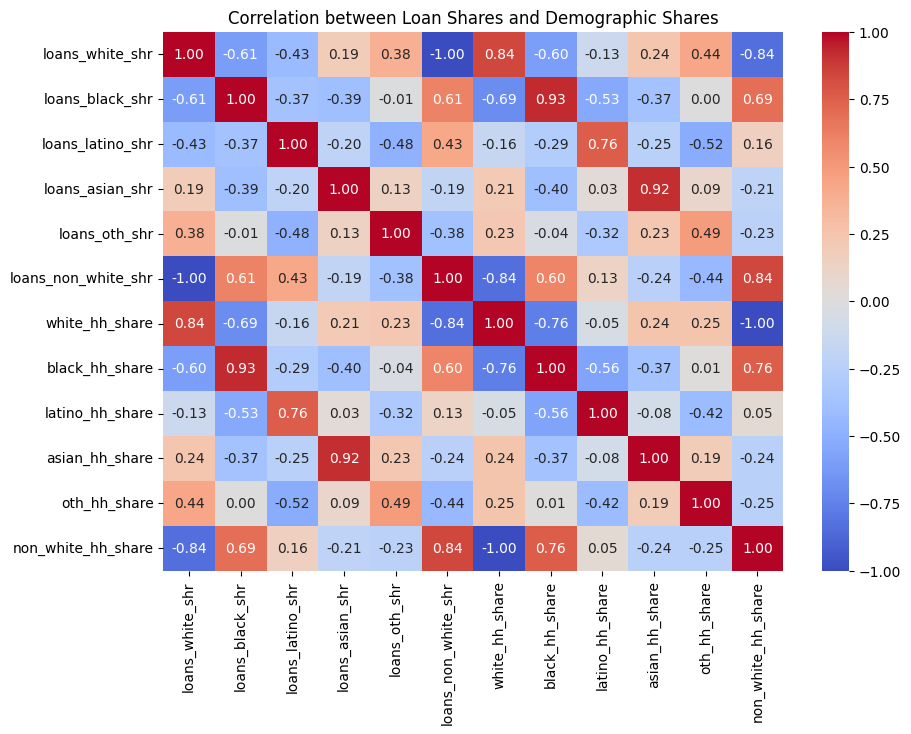

In [228]:
# analyzing the loan shares and dem shares and showing the correlation
corr_df = dfs[loan_shares + dem_shares].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Loan Shares and Demographic Shares")
plt.show()

Visualization #2 for chi_data set

Again this is heat map as already previously mentioned red squares show positive relationships, and blue squares show negative ones. Darker colors indicates stronger correlations.

The heatmap displays color coded correlations between income factors and loan shares

So basically what it means is that a positive value would show both variables increase together. A negative value means one goes up while the other goes down. Values that are almost near to zero mean there is little or no relationship. This would help to reveal how income levels connect to which racial groups receive loans.

Findings:

It shows how white loan share rises in higher-income neighborhoods. Black and overall non-white loan shares fall as income increases. Low-income labels alone do not predict loan patterns well, but AMI (means Area Median Income) levels do.

So mainly it means: wealthier areas give more loans to white borrowers and fewer to non-white borrowers.

Hypothesis: Neighborhood income influences racial distribution of loans

It would be interesting because patterns in lending might reflect socioeconomic and racial inequalities and also 
exploring this would help reveal systemic bias


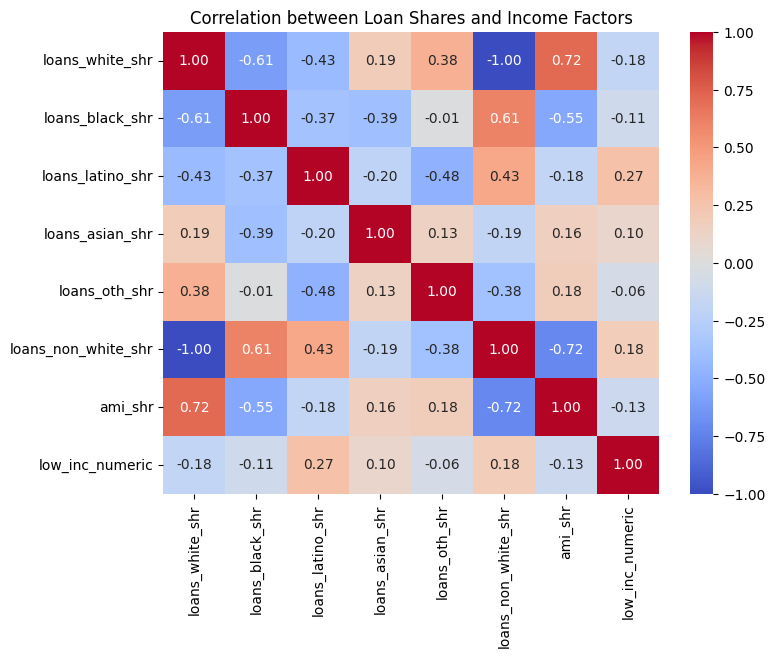

In [229]:
dfs['low_inc_numeric'] = dfs['low_inc'].apply(lambda x: 1 if x == 'low_inc' else 0)

corr_income = dfs[loan_shares + ['ami_shr', 'low_inc_numeric']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_income, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Loan Shares and Income Factors")
plt.show()


Visualization #3 for chi_data set

This boxplot shows the distribution of loan shares for each racial group across Chicago neighborhoods. The box represents the middle 50% of values. The line inside shows the median loan share. The whiskers show the overall range, and dots represent outliers. Each racial group has its own box to compare loan share patterns.

Basically for reading purposes the higher medians mean that a racial group receives a larger share of loans in most neighborhoods. Taller boxes mean there is more variation in loan shares from place to place. Very small boxes mean the loan share stays consistently low or stable across neighborhoods. Outliers show neighborhoods where loan shares are unusually high or low.

Findings / what does the box plot presents:

White borrowers have the highest median loan share and the widest spread. This means many neighborhoods give white borrowers a large share of loans. Black borrowers have a low median but a long upper whisker, showing that most areas give few Black loans, but a few areas give many. Latino borrowers fall in the middle with some high outliers. Asian and Other groups have very low and steady loan shares across the city. 

Mainly this graph shows: loan distribution is uneven, with white borrowers receiving much more access compared to non-white groups.

Hypothesis: That racial groups with higher median loan shares such as white borrowers may have greater access to credit 
or more frequently approved for loans across most chicago neighborhoods. Meanwhile groups consistently low or high
loan shares may face uneven access to lending opportunities depending on where they live

Its interesting because the visuals from boxplot clearly shows racial differences in loan shares and this raises
questions about weather access to credit is equal across groups or varies by neighborhood or not. 

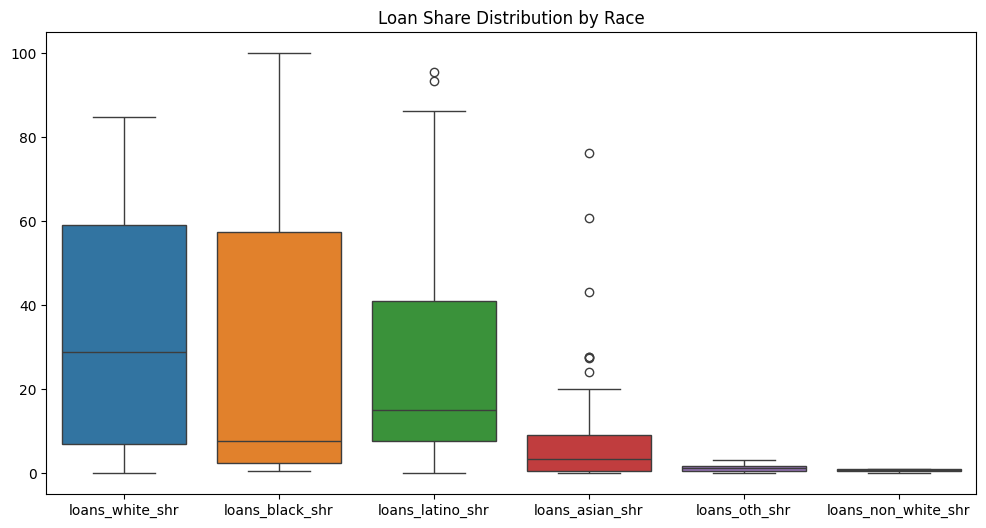

In [230]:
plt.figure(figsize=(12,6))
sns.boxplot(data=dfs[loan_shares])
plt.title("Loan Share Distribution by Race")
plt.show()


Visualization #4 for chi_data set

I have 3 scatterplots together to provide a clearly show how loan across Chicago varies with racial composition and income.

First scatterplot:

It compares the share of white households to the share of loans received by white borrowers, which shows positive relationship
because as the white household share increases white loan share also rises. Even in neighborhoods where white households make up a relatively small portion of the population white borrowers still receive a disproportionate share of total loan.

IN CONTRAST

Second scatterplot:

where it again compares the share of Black households to the share of loans going to Black borrowers, shows a very different pattern from the white scatterplot. Black borrowers are almost always getting fewer loans than we would expect based on how many Black people live in a neighborhood. Even in neighborhoods where most residents are Black, the amount of loan money going to Black borrowers stays very low. This suggests there is a clear and consistent gap in access to loans for Black communities.

Third scatterplot:

this just helps to explain why this gap exists. It compares the share of non-white residents to the income level (AMI) of each neighborhood. The plot shows a strong trend: the more non-white people a neighborhood has, the lower its income tends to be. Since income plays a big role in whether people can qualify for loans, this means many non-white neighborhoods start at a disadvantage

So overall we see: how white neighborhoods tend to receive more loans, while Black and other non-white neighborhoods receive fewer. These differences are not random they are connected to both race and income

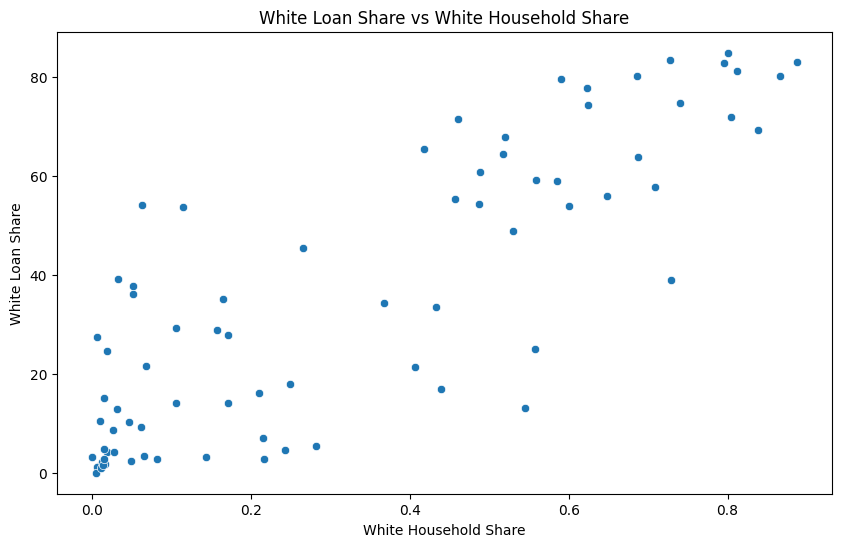

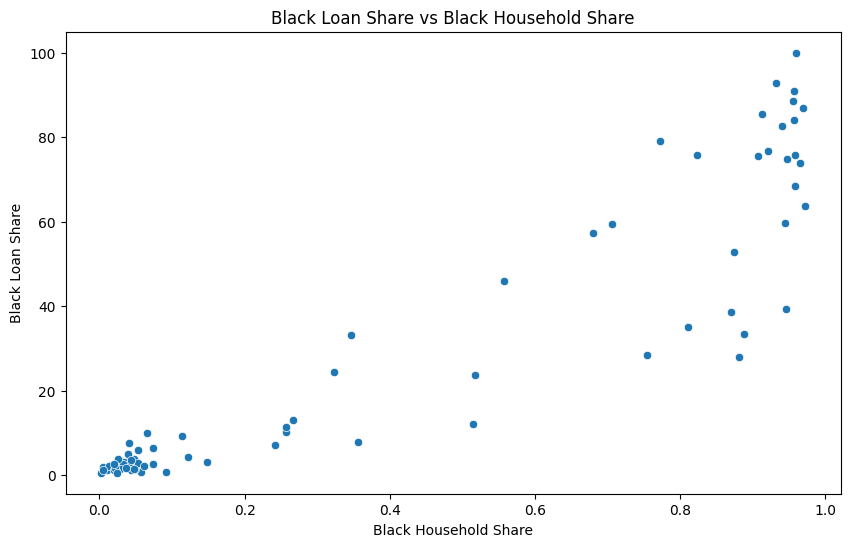

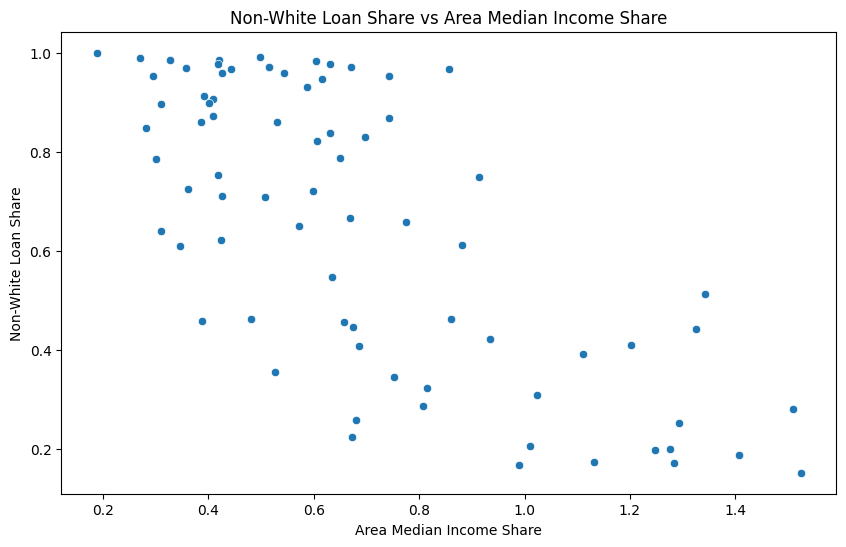

In [232]:
#visually showing the relationships/patterns
plt.figure(figsize=(10,6))
sns.scatterplot(x='white_hh_share', y='loans_white_shr', data=dfs)
plt.title("White Loan Share vs White Household Share")
plt.xlabel("White Household Share")
plt.ylabel("White Loan Share")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='black_hh_share', y='loans_black_shr', data=dfs)
plt.title("Black Loan Share vs Black Household Share")
plt.xlabel("Black Household Share")
plt.ylabel("Black Loan Share")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x='ami_shr', y='loans_non_white_shr', data=dfs)
plt.title("Non-White Loan Share vs Area Median Income Share")
plt.xlabel("Area Median Income Share")
plt.ylabel("Non-White Loan Share")
plt.show()

Visualization #5 for chi_data

Looking at the 3 of the graph altogether:

The Top 10 and Bottom 10 loan graphs show that loan dollars in Chicago are heavily concentrated in a small set of neighborhoods, and those high funding areas are dominated by White borrowers, who make up the majority of loan shares in every top funded community. 

In contrast, the lowest funding neighborhoods, many of which have larger Black and Latino populations, receive far smaller total loan amounts, even though their racial loan shares appear more mixed or more representative of their local populations

This pattern shows that investment is not only uneven but also racially structured. 

Hypothesis: that racially segregated neighborhoods receive racially segregated lending which means that even when minority neighborhoods receive loans, those loans remain small in total volume. 

This is interesting because it highlights that amount of share can be misleading (like even being most share about the value overall if we compare is so tiny) and it would connect the visual patterns in the graphs to long term questions about how race and geography shape economic opportunity in Chicago. 


TOP 10 COMMUNITIES BY TOTAL LOAN AMOUNT:
 community_area  total_loan_amount
      West Town         2242815000
      Lake View         2003905000
   Lincoln Park         1925535000
Near North Side         1575655000
   Logan Square         1296315000
 Near West Side         1096705000
   North Center          993415000
         Uptown          592745000
    Irving Park          564760000
Near South Side          560840000

BOTTOM 10 COMMUNITIES BY TOTAL LOAN AMOUNT:
    community_area  total_loan_amount
         Riverdale             250000
       Fuller Park            6155000
          Burnside            9765000
           Pullman           15225000
     South Deering           21930000
           Oakland           30095000
   Washington Park           30945000
     Armour Square           34055000
         Hegewisch           38200000
West Garfield Park           48380000


/var/folders/qt/jjs3n41936s1gz0kjsdc7rj80000gn/T/ipykernel_17819/236551427.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(val/1_000_000)}M' for val in y])
/var/folders/qt/jjs3n41936s1gz0kjsdc7rj80000gn/T/ipykernel_17819/236551427.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(val/1_000_000)}M' for val in y])


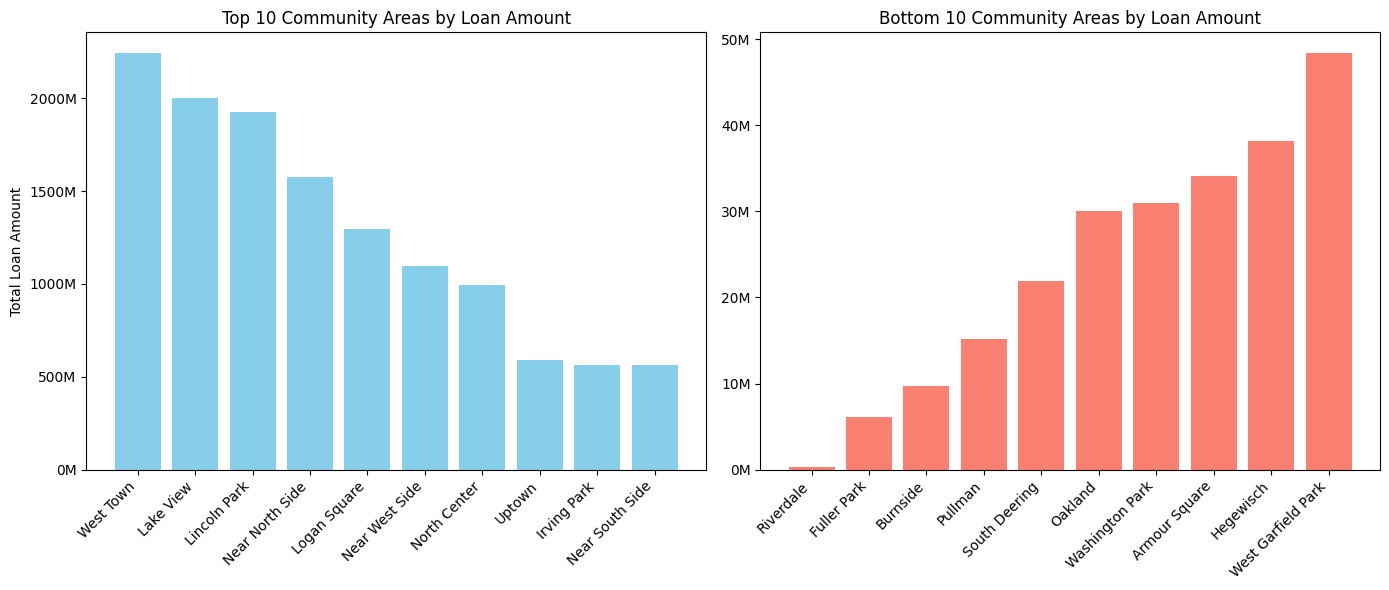

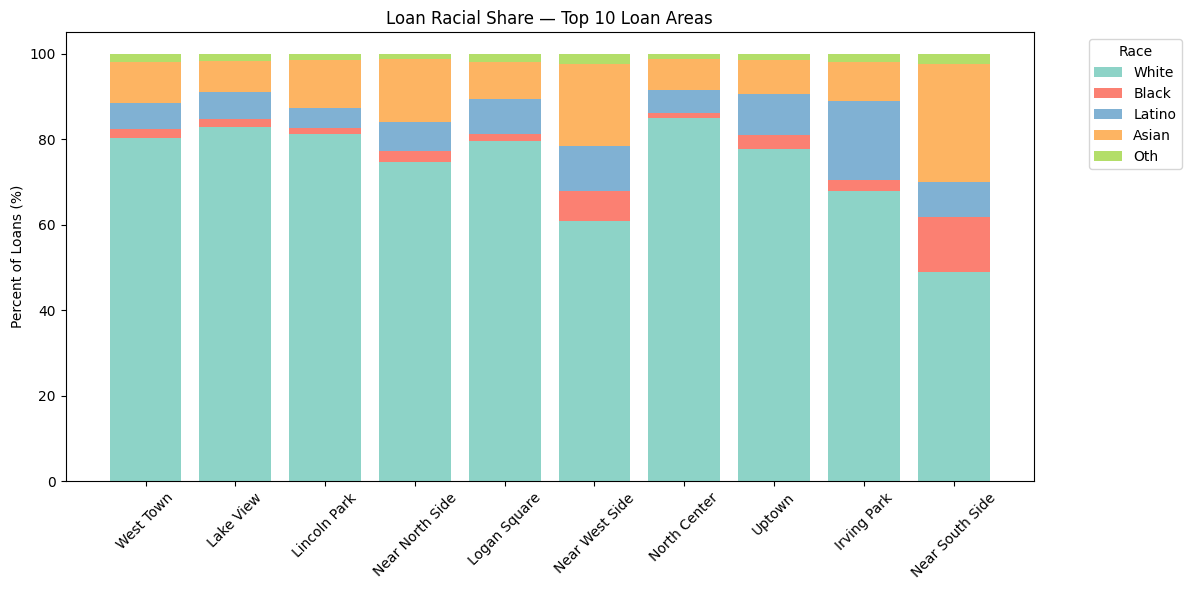

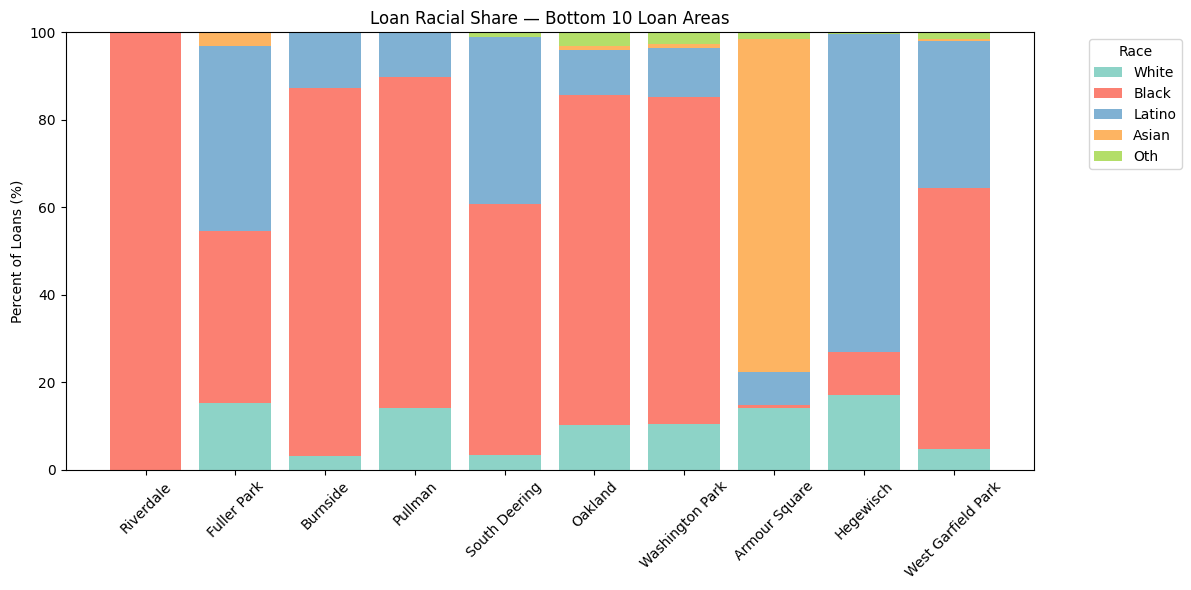

In [ ]:
import matplotlib.pyplot as plt

loan_by_community = dfs.groupby("community_area")["total_loan_amount"].sum().reset_index()
loan_by_community = loan_by_community.sort_values(by="total_loan_amount", ascending=False)

top10 = loan_by_community.head(10)
bottom10 = loan_by_community.tail(10).sort_values(by="total_loan_amount", ascending=True)

print("\nTOP 10 COMMUNITIES BY TOTAL LOAN AMOUNT:")
print(top10.to_string(index=False))

print("\nBOTTOM 10 COMMUNITIES BY TOTAL LOAN AMOUNT:")
print(bottom10.to_string(index=False))


plt.figure(figsize=(14,6))

# TOP 10
plt.subplot(1, 2, 1)
plt.bar(top10["community_area"], top10["total_loan_amount"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Community Areas by Loan Amount")
plt.ylabel("Total Loan Amount")
ax = plt.gca()
y = ax.get_yticks()
ax.set_yticklabels([f'{int(val/1_000_000)}M' for val in y])

# BOTTOM 10
plt.subplot(1, 2, 2)
plt.bar(bottom10["community_area"], bottom10["total_loan_amount"], color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title("Bottom 10 Community Areas by Loan Amount")
ax = plt.gca()
y = ax.get_yticks()
ax.set_yticklabels([f'{int(val/1_000_000)}M' for val in y])

plt.tight_layout()
plt.show()


race_cols = [
    "loans_white_shr",
    "loans_black_shr",
    "loans_latino_shr",
    "loans_asian_shr",
    "loans_oth_shr"
]
colors = {
    "loans_white_shr": "#8dd3c7",
    "loans_black_shr": "#fb8072",
    "loans_latino_shr": "#80b1d3",
    "loans_asian_shr": "#fdb462",
    "loans_oth_shr": "#b3de69"
}


loan_race = dfs[["community_area", "total_loan_amount"] + race_cols].copy()

top10 = loan_race.sort_values(by="total_loan_amount", ascending=False).head(10)
bottom10 = loan_race.sort_values(by="total_loan_amount", ascending=True).head(10)

def plot_race_share(data, title):
    plt.figure(figsize=(12,6))
    bottom = None

    for col in race_cols:
        plt.bar(
            data["community_area"],
            data[col],
            bottom=bottom,
            color=colors.get(col, None),
            label=col.replace("loans_", "").replace("_shr","").capitalize()
        )
        bottom = data[col] if bottom is None else bottom + data[col]

    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Percent of Loans (%)")
    plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_race_share(top10, "Loan Racial Share — Top 10 Loan Areas")
plot_race_share(bottom10, "Loan Racial Share — Bottom 10 Loan Areas")

